# ⚡️ Energy Based Models

In this notebook, we'll walk through the steps required to train your own Energy Based Model to predict the distribution of a demo dataset

## Table of contents
0. [Parameters](#parameters)
1. [Prepare the Data](#prepare)
2. [Build the EBM](#build)
3. [Train the EBM](#train)
4. [Generate images](#generate)

In [2]:
%load_ext autoreload
%autoreload 2

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

from sklearn import datasets

import tensorflow as tf
from tensorflow import keras
import tensorflow_probability as tfp

from utils.image import display
import random

import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

## 0. Parameters <a name="parameters"></a>

In [3]:
IMAGE_SIZE = 32
CHANNELS = 1
BATCH_SIZE = 128
EPOCHS = 60

In [4]:
# Load the data
(x_train, _), (_, _) = keras.datasets.fashion_mnist.load_data()

In [5]:
# Preprocess the data

def preprocess(imgs):
    """
    Normalize and reshape the images
    """
    imgs = (imgs.astype("float32") - 127.5) / 127.5
    imgs = np.pad(imgs , ((0,0), (2,2), (2,2)), constant_values= -1.0)
    imgs = np.expand_dims(imgs, -1)
    return imgs

x_train = preprocess(x_train)

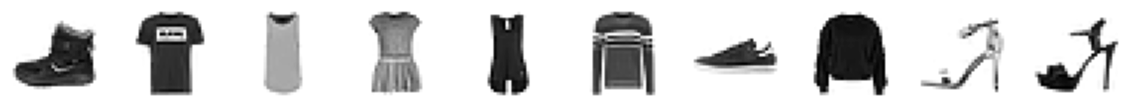

In [6]:
# Show some items of clothing from the training set
display(x_train)

## 2. Build the EBM network <a name="build"></a>

In [69]:
ebm_input = keras.layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
x = keras.layers.Conv2D(16, kernel_size=4, strides=2, padding="same")(ebm_input)
x = keras.layers.LeakyReLU(0.2)(x)
x = keras.layers.Conv2D(32, kernel_size=4, strides=2, padding="same")(x)
x = keras.layers.LeakyReLU(0.2)(x)
x = keras.layers.Conv2D(64, kernel_size=4, strides=2, padding="same")(x)
x = keras.layers.LeakyReLU(0.2)(x)
x = keras.layers.Conv2D(1, kernel_size=4, strides=1, padding="valid")(x)
ebm_output =  keras.layers.Flatten()(x)
ebm_model = keras.Model(ebm_input, ebm_output)
ebm_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 32, 32, 1)]       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 16, 16, 16)        272       
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 16, 16, 16)        0         
                                                                 
 conv2d_13 (Conv2D)          (None, 8, 8, 32)          8224      
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 8, 8, 32)          0         
                                                                 
 conv2d_14 (Conv2D)          (None, 4, 4, 64)          32832     
                                                                 
 leaky_re_lu_11 (LeakyReLU)  (None, 4, 4, 64)          0   

In [70]:
class Sampler:
    def __init__(self, model, img_shape, sample_size, max_len=8192):
        super().__init__()
        self.model = model
        self.img_shape = img_shape
        self.sample_size = sample_size
        self.max_len = max_len
        self.examples = [tf.random.uniform(shape = (1, IMAGE_SIZE,IMAGE_SIZE,CHANNELS)) * 2 - 1 for _ in range(sample_size)]
                         
    def sample_new_exmps(self, steps=60, step_size=10):
        n_new = np.random.binomial(self.sample_size, 0.05)
        rand_imgs = tf.random.uniform((n_new,) + self.img_shape) * 2 - 1
        old_imgs = tf.concat(random.choices(self.examples, k=self.sample_size-n_new), axis=0)
        inp_imgs = tf.concat([rand_imgs, old_imgs], axis=0)
        inp_imgs = self.generate_samples(self.model, inp_imgs, steps=steps, step_size=step_size)
        self.examples = tf.split(inp_imgs, self.sample_size, axis = 0) + self.examples
        self.examples = self.examples[:self.max_len]
        return inp_imgs

    @staticmethod
    def generate_samples(model, inp_imgs, steps=60, step_size=10, return_img_per_step=False):
        imgs_per_step = []
        for _ in range(steps):
            inp_imgs += tf.random.normal(inp_imgs.shape, 0, 0.005)
            inp_imgs = tf.clip_by_value(inp_imgs, -1.0, 1.0)
            with tf.GradientTape() as tape:
                tape.watch(inp_imgs)
                out_score = -model(inp_imgs)
                out_score = tf.clip_by_value(out_score, -0.03, 0.03)
            grads = tape.gradient(out_score, inp_imgs)
            inp_imgs += -step_size * grads
            inp_imgs = tf.clip_by_value(inp_imgs, -1.0, 1.0)
            if return_img_per_step:
                imgs_per_step.append(inp_imgs)
        if return_img_per_step:
            return tf.stack(imgs_per_step, axis=0)
        else:
            return inp_imgs

In [82]:
class EBM(keras.Model):
    def __init__(self):
        super(EBM, self).__init__()
        self.cnn = ebm_model
        self.sampler = Sampler(self.cnn, img_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS), sample_size=BATCH_SIZE)
        self.alpha = 0.1
        self.loss_metric = keras.metrics.Mean(name="loss")
       
    @property
    def metrics(self):
        return [self.loss_metric]
    
    def train_step(self, real_imgs):
        real_imgs += tf.random.normal(shape=tf.shape(real_imgs)) * 0.005
        real_imgs = tf.clip_by_value(real_imgs, -1.0, 1.0)
        fake_imgs = self.sampler.sample_new_exmps(steps=60, step_size=10)
        inp_imgs = tf.concat([real_imgs, fake_imgs], axis=0)
        inp_imgs = tf.stop_gradient(inp_imgs)
        with tf.GradientTape() as training_tape:
            real_out, fake_out = tf.split(self.cnn(inp_imgs, training = True), 2, axis=0)
            reg_loss = self.alpha * tf.reduce_mean(real_out ** 2 + fake_out ** 2, axis = 0)
            cdiv_loss = tf.reduce_mean(fake_out - real_out, axis = 0)
            loss = reg_loss + cdiv_loss
        grads = training_tape.gradient(loss, self.cnn.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.cnn.trainable_variables))
        self.loss_metric.update_state(loss)
        return {m.name: m.result() for m in self.metrics}

In [83]:
ebm = EBM()

## 3. Train the EBM network <a name="train"></a>

In [84]:
# Compile and train the model
ebm.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), run_eagerly=True)

In [85]:
tensorboard_callback = keras.callbacks.TensorBoard(log_dir="./logs")

In [86]:
ebm.fit(
    x_train
    , batch_size=BATCH_SIZE
    , epochs=EPOCHS
    , callbacks = [tensorboard_callback]
)

Epoch 1/10
 11/469 [..............................] - ETA: 20:35 - loss: -4.8502

KeyboardInterrupt: 

## 4. Generate images <a name="generate"></a>

In [61]:
start_imgs = np.random.uniform(size = (10,32,32,1)) * 2 - 1

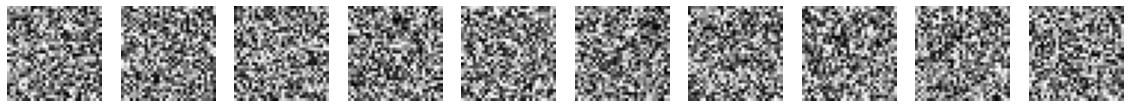

In [62]:
display(start_imgs)

In [63]:
imgs_per_step = Sampler.generate_samples(ebm.cnn, start_imgs, steps=256, step_size=10, return_img_per_step=True)

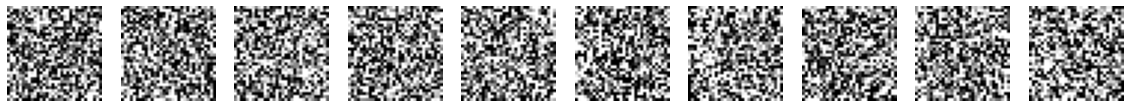

In [64]:
display(imgs_per_step[-1].numpy())

In [65]:
imgs_per_step[-1].numpy()

array([[[[ 0.11898483],
         [-0.2806019 ],
         [-1.        ],
         ...,
         [ 1.        ],
         [ 0.1520926 ],
         [ 0.77237505]],

        [[ 0.60239387],
         [-1.        ],
         [ 1.        ],
         ...,
         [-1.        ],
         [-0.7281163 ],
         [ 0.00703655]],

        [[-1.        ],
         [ 1.        ],
         [ 0.75525856],
         ...,
         [ 1.        ],
         [ 1.        ],
         [ 0.3001024 ]],

        ...,

        [[ 1.        ],
         [-1.        ],
         [-1.        ],
         ...,
         [-1.        ],
         [-1.        ],
         [ 0.81791776]],

        [[-1.        ],
         [-0.00824824],
         [-1.        ],
         ...,
         [ 0.28863943],
         [-0.2514667 ],
         [-1.        ]],

        [[ 0.3904255 ],
         [-0.8482926 ],
         [ 0.40057382],
         ...,
         [ 1.        ],
         [-1.        ],
         [ 1.        ]]],


       [[[-1.        ],
